In [1]:
import numpy as np
import librosa
from librosa.display import waveplot, specshow
import matplotlib.pyplot as plt
import IPython.display as ipd
import tikzmagic
from ipywidgets import interactive
import ipywidgets as widgets

from speech_tools import *
%reload_ext autoreload
%autoreload 2

# __Cours de Traitement du Signal de la Parole__
## __Département Génie Electrique et Informatique__
## __Filière GSEII S5__  
## __Année universitaire 2019-2020__
### _Professeur H. Belkebir_

## __Plan du cours__

>### __1. Introduction__
>### __2. Generatlités sur le signal de la parole__
>### __3. Analyse spectro-temporelle du signal de la parole__
>### __4. Modélisation Paramétrique du signal de la parole__
>### __5. Codage numérique du signal de la parole__

### __1. Introduction__


> If i could determine what there is in the verry rapidely changing complex speech wave that corresponds to the simple motion of the lips and tongue. If i could then analyze speech for these quantities. I would have a set of speech defining signals that be handeled as low frequency telegraph currents with resulting advantages of secrecy, and more telephone channels in the same frequency space as well as a basis understanding of the carrier nature of speech by which the lip reader interptrets speech from simple motion
                                                                                                                 Hommer Dedely
 
   |![Image](images/hommer_dedely.jpeg)|
   |-----------------------------------|

### 1.1 Qu'est ce que la parole ?
>* Définition : 
La parole est un signal acoustique produit par notre système phonatoire pour servir de vecteur à l'informations générées par notre cerveau dans le cadre d'un processus de communication.

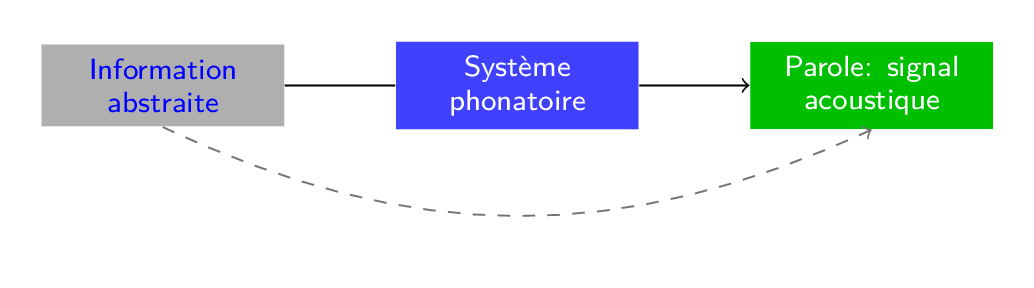

In [2]:
%%tikz --scale=1.0 --border=10
\usetikzlibrary{decorations.markings}
\tikzset{every node/.style={font=\scriptsize\sffamily,white,text width =0.15\textwidth,align=center}}
\node[rectangle,fill=gray!75,text=blue] at (0,0) (a) {Information abstraite};
\node[rectangle,fill=blue!75] at (3,0)(b){Système phonatoire};
\node[rectangle,fill=green!75!black] at (6,0)(c){Parole: signal acoustique};
\draw[->,black] (a) -- (b)--(c);
\draw[->,dashed,gray!75!black] (a.south) to[bend right=25](c.south);

### 1.2 Pourquoi le traitement numérique de la parole (Numerical Speech Proceccing) ?
>1. La parole constitue la modalité principale de communication entre êtres humains;

>2. Elle est de plus en plus utilisé dans l'interaction multimodale homme-machine;

>3. Elle relève plusieurs défis théoriques et technologiques à cause de sa richesse et sa conplexité.

### 1.3 Sur quoi porte le NSP ?
>1. Elaboration des modèles mathématiques et des techniques pratiques qui facilite:
  1. La représentation;
  2. La restauration;
  3. L'analyse;
  4. L'estimation;
  5. La reproduction;
  6. La communication;
  7. Le stockage du signal de la parole.

### 1.4 Quels sont les domaines d'application du NSP ?
>1. Traduction et transcription de la parole;
>2. Identification et contrôle vocale des systèmes;
>3. Intéraction homme-machine multimodale.

## __2. Généralités sur le signal de la parole__ 
### 2.1 Système de production de la parole
#### 2.1.1 Anatomie du Conduit vocale

   |![Image](images/pic1.png)|
   |-------------------------|

#### 2.1.2 Diagramme schématique du conduit vocal

   ![Image](images/sys_phon.jpg)

#### 2.1.2 Propriétées du signal de la parole :

>1. La parole est une séquence de sons continuement variables;
>2. Les propriétés du signal de la parole sont fortement corrélées aux sont utilisés pour coder implicitement les informations générées par le cerveau.
>3. Le signal acoustique véhiculant la parole est largement conditionné par le phénomène de co-articulation.
>4. La configuration du conduit vocal (état des cordes vocales, nombres et positions des articulations, état du système de radiation) est une fonction à variation lente dans le temps ce qui permet de produire les différents sons formant la parole. 

##### Example : de séquence de la parole :
> \"Should we chase\" ====> \"(/SH.UH.D/ - /W.IY/ - /CH.EY.S/, /S,Ud/ /w.i:/ /tS/'eI.s/\")

In [3]:
snd, sr = librosa.load('audio/should_we_chase.wav')
snd = snd/snd.max()
ZC = zero_crossing(snd, 0.02, sr, winname='boxcar')
E = st_energy(snd, 0.02, sr)
E=E/E.max()
X = librosa.stft(snd,window='hamming',win_length=int(0.02*sr))
Xdb = librosa.amplitude_to_db(abs(X))
ipd.Audio(snd, rate=sr)

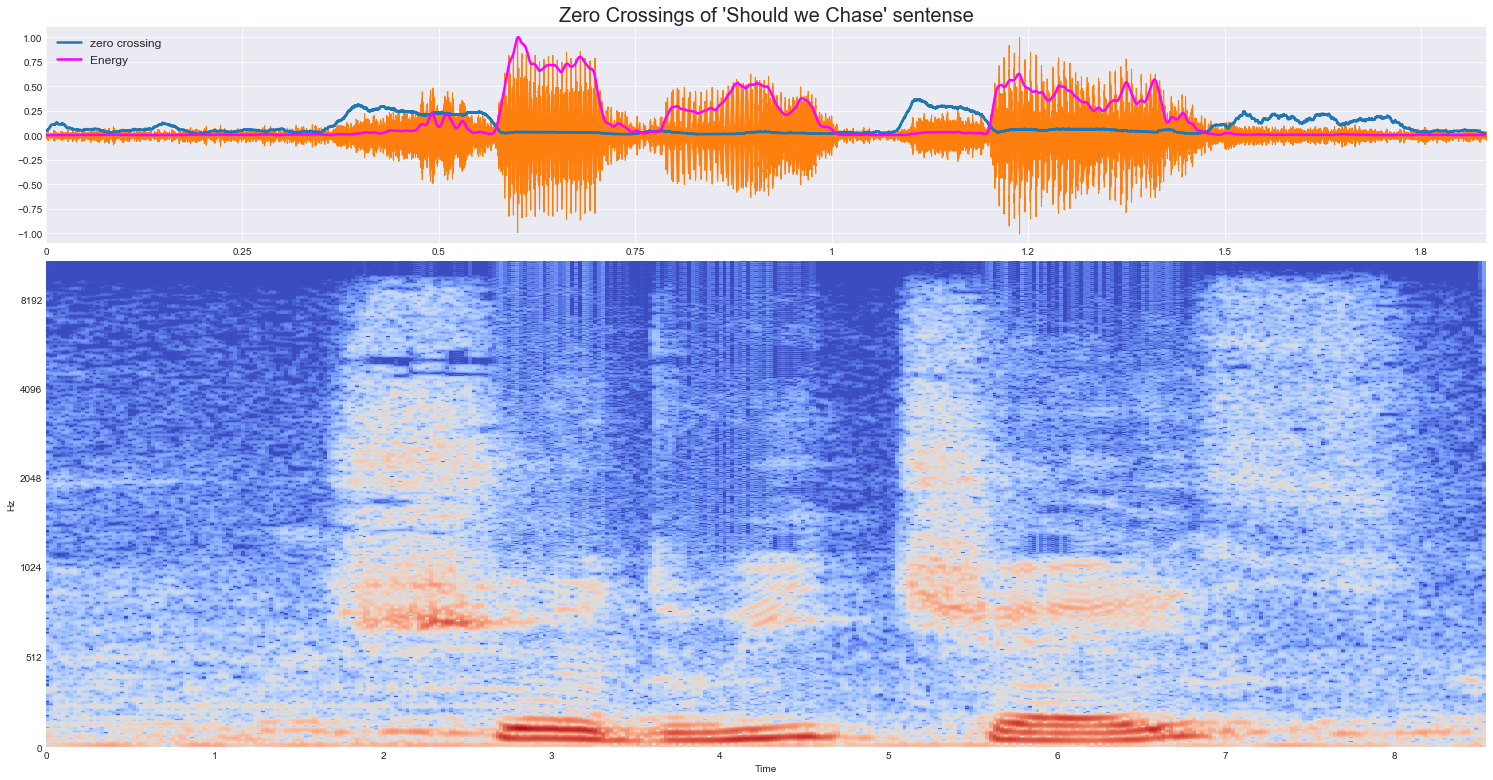

In [4]:
%matplotlib inline
plt.style.use("seaborn-dark")
plt.figure(figsize=(20,10))
ax=plt.axes([0 , 0.7, 1, 0.3])
tt = np.arange(0,ZC.size)/sr
ax.plot(tt,ZC,lw=2.5,label='zero crossing')
ax.plot(tt,E,color="magenta",lw=2.5,label='Energy')
ax.set_title("Zero Crossings of 'Should we Chase' sentense",fontsize=20)
#ax.annotate('Fricative sourde',fontsize=12, xy=(1.3, 0.3), xytext=(1.5, 0.7),arrowprops=dict(facecolor='cyan', shrink=0.05))
#ax.annotate('Fricative voisée',fontsize=12, xy=(7.6, 0.75), xytext=(8, 0.5),arrowprops=dict(facecolor='magenta', shrink=0.05))
waveplot(snd, sr=sr)
ax.legend(fontsize=12,loc='upper left')
ax.grid(True)
plt.axes([0 , 0 , 1, 0.675])
specshow(Xdb, sr=sr, x_axis='time', y_axis='mel')

### 2.1.3 Quelques éléments de phonétiques :
Les sons utilisés en langage naturel peuvent être classé selon leur mode de production. En générale, on distingue deux modes de production principale :
1. Le voisement : 
Dans ce mode de production, le conduit vocal est excité par une onde acoustique glottale quasi-périodique qui s'y propage librement jusqu'à la sortie où elle sera rayonnée vers l'extérieur par le biais du système de radiation;
2. L'articulation : 
Dans ce mode, le flux d'air en provenance des poumons est soumis à plusieurs contraintes (friction ou/et occlusion) avant d'être relaché par le système de radiation.

Il en découle de cette distinction entre les modes de production deux grandes familles de sons élémentaires :
1. Les voyelles produit par le processus de voisement.
2. Les consonnes produits par le processus d'articulation.

##### Example 1 : voyelles 
> A, E, U et I

In [5]:
snd, sr = librosa.load('audio/AEUI.wav')
snd = snd/snd.max()
ZC = zero_crossing(snd, 0.02, sr)
E = st_energy(snd, 0.02, sr)
E=E/E.max()
X = librosa.stft(snd,window='hamming',win_length=int(0.04*sr))
Xdb = librosa.amplitude_to_db(abs(X))
ipd.Audio(snd, rate=sr)

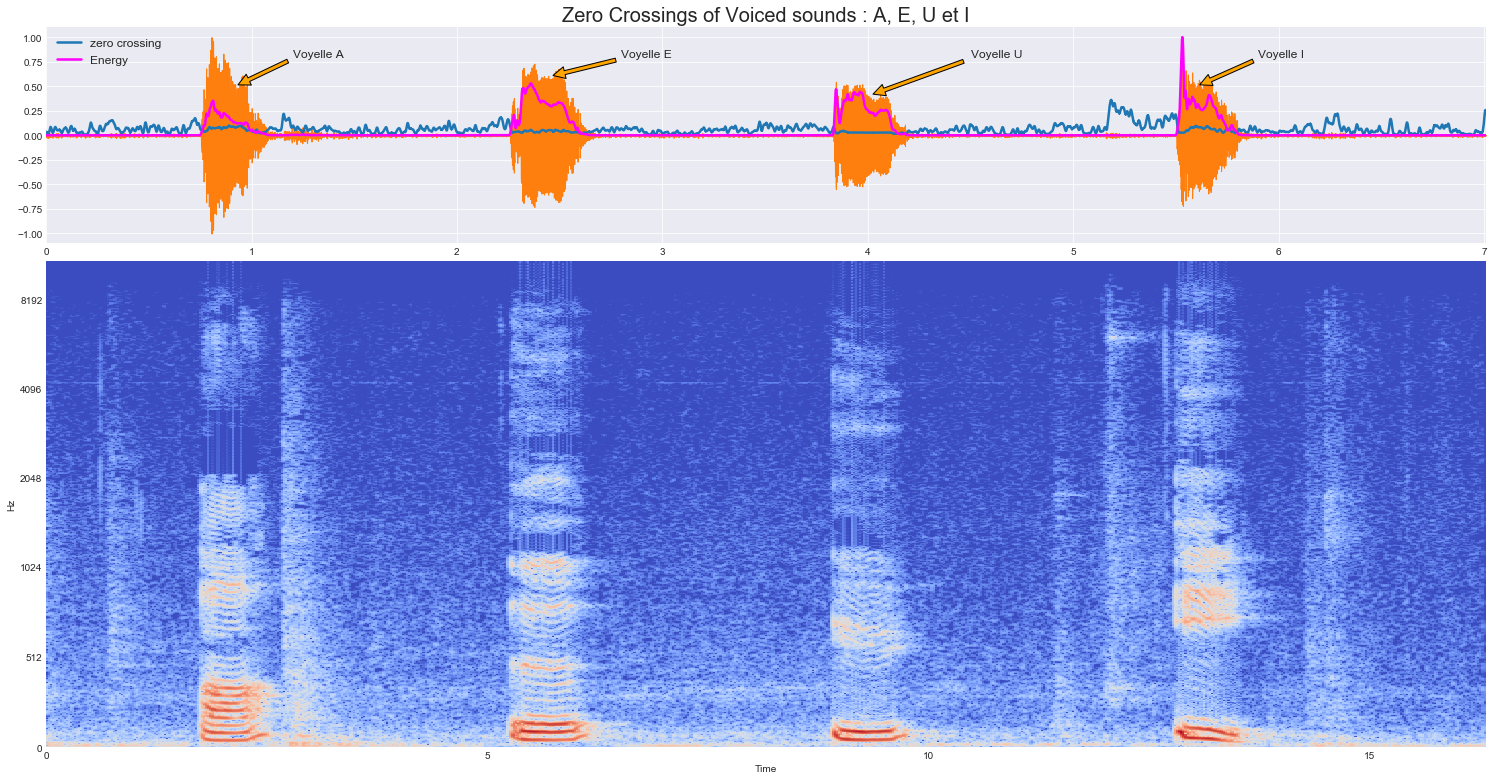

In [6]:
plt.figure(figsize=(20,10))
ax=plt.axes([0 , 0.7, 1, 0.3])
tt = np.arange(0,ZC.size)/sr
ax.plot(tt,ZC,lw=2.5,label='zero crossing')
ax.plot(tt,E,color="magenta",lw=2.5,label='Energy')
ax.set_title("Zero Crossings of Voiced sounds : A, E, U et I",fontsize=20)
ax.annotate('Voyelle A',fontsize=12, xy=(0.92, 0.5), xytext=(1.2, 0.8),arrowprops=dict(facecolor='orange', shrink=0.05))
ax.annotate('Voyelle E',fontsize=12, xy=(2.45, 0.6), xytext=(2.8, 0.8),arrowprops=dict(facecolor='orange', shrink=0.05))
ax.annotate('Voyelle U',fontsize=12, xy=(4., 0.4), xytext=(4.5, 0.8),arrowprops=dict(facecolor='orange', shrink=0.05))
ax.annotate('Voyelle I',fontsize=12, xy=(5.6, 0.5), xytext=(5.9, 0.8),arrowprops=dict(facecolor='orange', shrink=0.05))
#ax.annotate('Fricative voisée',fontsize=12, xy=(7.6, 0.75), xytext=(8, 0.5),arrowprops=dict(facecolor='magenta', shrink=0.05))
waveplot(snd, sr=sr);
ax.legend(fontsize=12,loc='upper left')
ax.grid(True)
plt.axes([0 , 0 , 1, 0.675])
specshow(Xdb, sr=sr, x_axis='time', y_axis='mel');

##### Example 2 : Consones occlusives 
> B, D et G

In [7]:
snd, sr = librosa.load('audio/BDG.wav')
snd = snd/snd.max()
ZC = zero_crossing(snd, 0.02, sr)
E = st_energy(snd, 0.02, sr)
E= E/E.max()
X = librosa.stft(snd,window='hamming',win_length=int(0.04*sr))
Xdb = librosa.amplitude_to_db(abs(X))
ipd.Audio(snd, rate=sr)

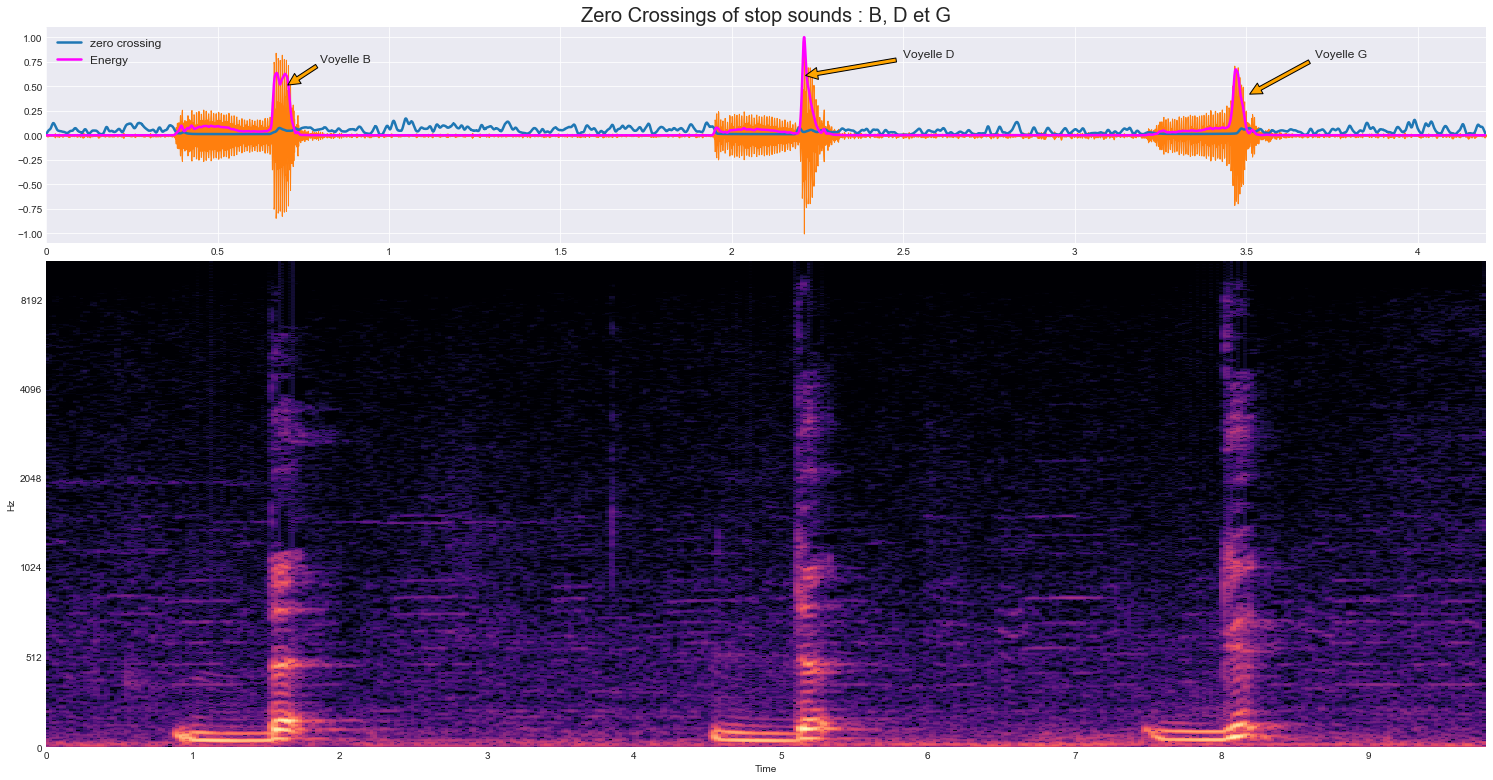

In [8]:
plt.figure(figsize=(20,10))
ax=plt.axes([0 , 0.7, 1, 0.3])
tt = np.arange(0,ZC.size)/sr
ax.plot(tt,ZC,lw=2.5,label='zero crossing')
ax.plot(tt,E,color="magenta",lw=2.5,label='Energy')
ax.set_title("Zero Crossings of stop sounds : B, D et G",fontsize=20)
ax.annotate('Voyelle B',fontsize=12, xy=(0.7, 0.5), xytext=(0.8, 0.75),arrowprops=dict(facecolor='orange', shrink=0.05))
ax.annotate('Voyelle D',fontsize=12, xy=(2.2, 0.6), xytext=(2.5, 0.8),arrowprops=dict(facecolor='orange', shrink=0.05))
ax.annotate('Voyelle G',fontsize=12, xy=(3.5, 0.4), xytext=(3.7, 0.8),arrowprops=dict(facecolor='orange', shrink=0.05))
#ax.annotate('Fricative voisée',fontsize=12, xy=(7.6, 0.75), xytext=(8, 0.5),arrowprops=dict(facecolor='magenta', shrink=0.05))
waveplot(snd, sr=sr);
ax.legend(fontsize=12,loc='upper left')
ax.grid(True)
plt.axes([0 , 0 , 1, 0.675])
specshow(Xdb, sr=sr, x_axis='time', y_axis='mel');

##### Example 3 : consones fricatives 
> F, S, CH et TH

In [9]:
snd, sr = librosa.load('audio/FSCHTH.wav')
snd = snd/snd.max()
ZC = zero_crossing(snd, 0.02, sr)
E = st_energy(snd, 0.02, sr)
E = E/E.max()
X = librosa.stft(snd,window='hamming',win_length=int(0.02*sr))
Xdb = librosa.amplitude_to_db(abs(X))
ipd.Audio(snd, rate=sr)

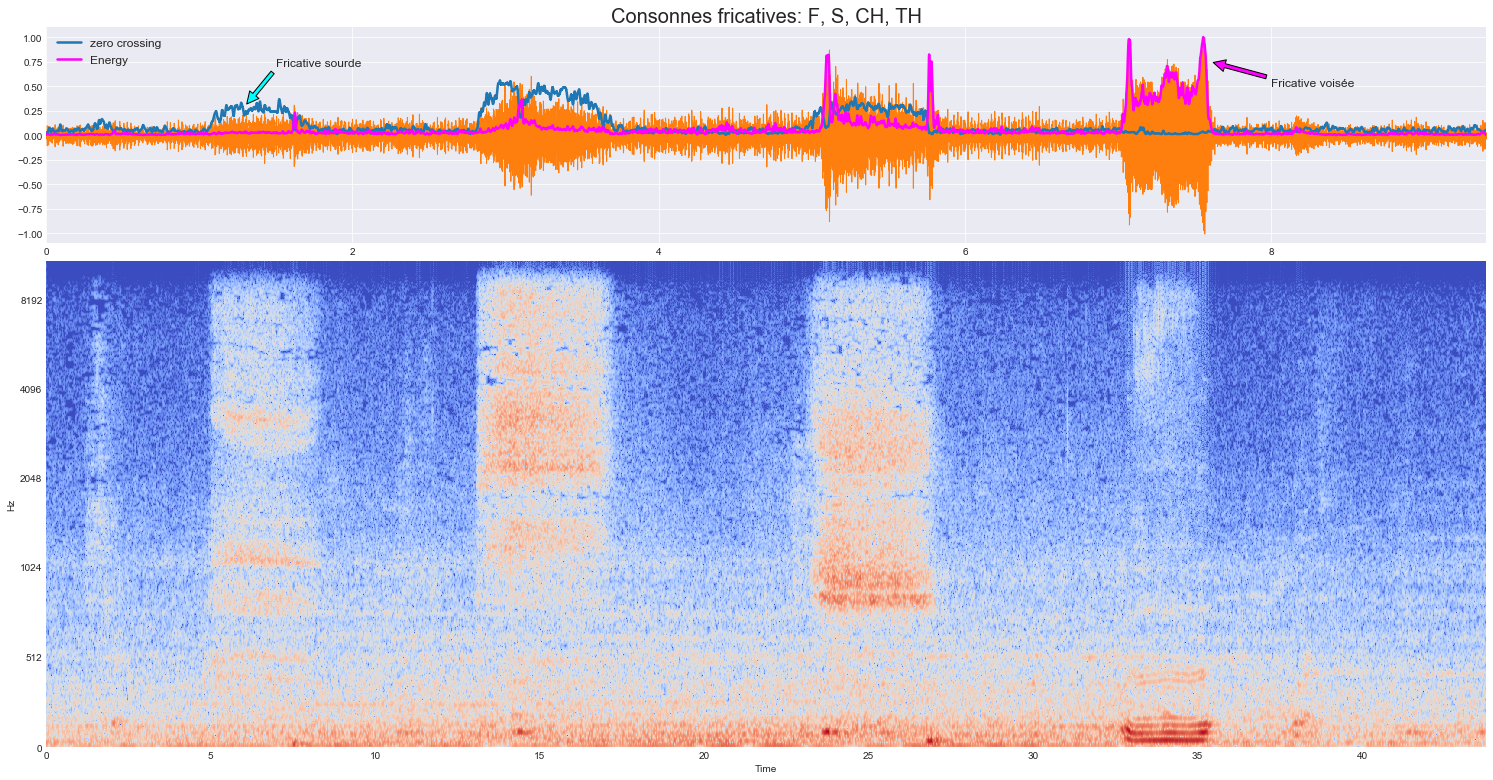

In [10]:
plt.figure(figsize=(20,10))
ax=plt.axes([0 , 0.7, 1, 0.3])
tt = np.arange(0,ZC.size)/sr
ax.plot(tt,ZC,lw=2.5,label='zero crossing')
ax.plot(tt,E,color="magenta",lw=2.5,label='Energy')
ax.set_title('Consonnes fricatives: F, S, CH, TH',fontsize=20)
ax.annotate('Fricative sourde',fontsize=12, xy=(1.3, 0.3), xytext=(1.5, 0.7),arrowprops=dict(facecolor='cyan', shrink=0.05))
ax.annotate('Fricative voisée',fontsize=12, xy=(7.6, 0.75), xytext=(8, 0.5),arrowprops=dict(facecolor='magenta', shrink=0.05))
waveplot(snd, sr=sr);
ax.legend(fontsize=12,loc='upper left')
ax.grid(True)
plt.axes([0 , 0 , 1, 0.675])
specshow(Xdb, sr=sr, x_axis='time', y_axis='mel');

##### 2.1.3.1 Attributs distinctifs des sons élémentaires:
>* Articulation :
On veut dire par articulation tout organe interne mobile du système vocale qui permet de changer la configuration du conduit vocale pour produire les différents sons (voyelles et consonnes).
>* Points d'articulation :
  1. Consonnes :
     |Labiale|Apicale|Dorsale|Pharyngale|Glottale|
     |-------|-------|-------|----------|--------|
     |Bilabiale|Dentale|Palatale|       |        |
     |Labio-vélaire|alvéolaire|vélaire| |        |
     |       |Laminale|uvulaire|        |        |
     |       |rétroflexe|      |        |        |
  
>* Modes d'articulation :
  1. Voyelles :
     |Antérieure | Postérieure|
     |-----------|------------|
     |Arrondie   | Non-arrondie|
     |Ouverte|Fermée|
     |Nasale|Orale|
  2.Consonnes :
     |Occlusive |Fricative |Affriquée |Latérale |Nasale |Clic |
     |----------|----------|----------|---------|-------|-----|


### 2.2 Système d'audition
La compréhension du signal de la parole necessite aussi l'investigation du système d'audition:

|![Image](images/loc_aud.png)|
|----------------------------|

#### 2.2.1 Anatomie de l'oreille :

|![Image](images/oreille.png)|![Image](images/basilar.png) |
|----------------------------|----------------------------|

#### 2.2.2 Diagramme schématiques des fonctions de l'oreille :

|![Image](images/bloc_diag.png)|
|------------------------------|

#### 2.2.3 Attributs physiques et perceptuels de la parole

>* Fréquence   $\Longrightarrow$ Pitch (échelle non-linéaire);
>* L'intensité $\Longrightarrow$ Sonnie (Amplitude sur une échelle non-linéaire);
>* Processus d'intégration spectrale long-terme $\Longrightarrow$ Perception des syllabes;
>* Phénomène du masquage sonore.

##### 2.2.3.1 Intensité sonore :
> En général, le son de la parole possède un patron complexe de variation de la pression acoustique. Cet grandeur est mesurable par le biais de la pression acoustique $\text{P}$ ou l'intensité acoustique $\text{I}$.
>* Définition : 
L'intensité acoustique est le flux d'énergie moyen par unité de sufrace, elle s'exprime en $\text{Watt}/m^2$.
>* Intervalle de variation de l'$\text{I}$ :
L'intensité acoustique $\text{I}$ varie du seuil d'audition ($10^{-12} [W/m^2]$) jusqu'au seuil de douleur ($10 [W/m^2]$)
>* Niveau d'intensité acoustique $\text{IL}$ :
$$ \text{IL} = 10 \log_{10}\left(\frac{I}{I_0}\right),\;\text{avec}\; I_0 = 10^{-12} [W/m^2]$$
>* Dans le cas des sons tonales, le niveau d'intensité acoustique s'exprime en :
$$ \text{IL} = 20 \log_{10}\left(\frac{P}{P_0}\right),\;\text{avec}\; P_0 = 2\times 10^{-5} [Pa]$$

|![Image](images/pic9.png)|
|-------------------------|

#### 2.2.3.2 Niveau de sonnie :
> * Définition :
  Le niveau de sonnie $\text{LL} [phons]$ d'une tonalité à une fréquence donnée $f_0$ est le niveau d'intensité ou de pression acoustique d'une tonalité à $1 [kHz]$ perçu comme étant égale à l'intensité de la tonalité sous investigation.
  
|![Image](images/iso_LL.png)|
|---------------------------|

#### 2.2.3.3 Sonnie (Loundness) $\text{L}[sonnes]$

|![Image](images/Loudness.png)|
|---------------------------|

$$ L= 2^{(LL-40)/10},\;\forall\, \text{LL}\in[20,120] $$ 

#### 2.2.3.4 Pitch 
> Notre système auditif exhibe des performances hors du commun. Il est capable par exemple de percevoir une composante haute fréquence à un niveau de sonnie très faible chose qu'on du mal à gérer lors du codage numérique du son (problème du limit-cycle of waveform coders). Il souffre aussi du problème/avantage de ne pas détecter le bruit ou les tonalités en présence d'une tonalité forte (phénomène de masquage). La grandeur perceptuelle attachée à la fréquence est le pitch, toutefois comme c'était le cas pour la sonnie, cette grandeur dépend aussi de la sonnie avec une grande corrélation avec la fréquence. 

|![Image](images/pitch.png)|
|--------------------------|

$$\text{pitch}[mel]=1127\log\left(1+f[Hz]/700\right)$$

> La notion de pitch tel qu'elle est représenté par l'échelle de mel peut être relayée au concept de bande critique. Notre compréhension de cette grandeur psychoacoustique renforce notre conaissance à propos du système d'audition et qu'il performe une analyse fréquentiel du son plutôt que temporel pour inférer ses attrributs descriminatifs. On peut simuler son comportement en utilisant des bancs de filtres passe-bandes à bande passante croissante en fonction de leur fréquence centrale.  

#### 2.2.3.5 Effet de masquage :
> Le masquage est le phénomène durant lequel certains sons deviennent moins distingués ou même inaudibles en présence d'autres sons. Le masquage est un effet très compliqué toutefois on peut toujours étudier ses réalisations les plus simples en consdérant d'abord le masque et le son masqué comme des tonalités. 

>1. Effet de masquage de tonalité :
|![Image](images/masque1.png)|
|----------------------------|

>On remarque que :
 * Le phénomène de masquage est plus prononcé pour les fréquences au-dessus de la fréquence du masque;
 * Le masquage est moins effective pour les grands niveaux de sonnie;
 * La courbe de masquage présente des notches au voisinage de la fréquence du masque.

>2. Masquage temporel :
|![Image](images/masque2.png)|
|----------------------------|

> Le phénomène de masquage est très utilisé dans le codage du son (MP3, AAC comme exemples).


### 2.2.4 Modèles auditifs 
> Les connaissances aquis de la compréhension du fonctionnement du système d'audition ont amenés les chercheurs à développer plusieurs modèles auditifs incluant les effets perceptuels suivants :
* Analyse spectrale du son sur une échelle non-linéaire;
* Compression des sonnies et de l'amplitude spectrale;
* Atténuation de la sensibilité aux basses fréquences en se reférant au diagramme des isosonnies;
* utilisation des attributs temporels par le biais de l'intégration spectrale long-terme;
* Masquage auditifs

#### 2.2.4.1 Prédiction linéaire perceptuelle
> |![Image](images/plp.png)|
|----------------------------|

$$\text{Bark} = 6 \sinh^{-1}\left(\frac{f[Hz]}{600}\right)$$

#### 2.2.4.1 Modèle auditif de Seneff :
> |![Image](images/seneff.png)|
|----------------------------|
|![Image](images/seneff_output.png)|

#### 2.2.5 Modèle source-filtre du système phonatoire
|![Image](images/modele_SF.png)|
|------------------------------|
$$
\begin{aligned}
-\frac{\partial p}{\partial x}&=\rho\frac{\partial(u/A)}{\partial t}\\
-\frac{\partial u}{\partial x}&={1\over{\rho c^2}}\frac{\partial(p A)}{\partial t}+\frac{\partial A}{\partial t}\\
\end{aligned}
$$

##### 2.2.5.1 Solution de l'équation d'onde pour un tube rigide à section constante 
$$\frac{\partial^2 u}{{\partial x}^2}={1\over c^2}\frac{\partial^2 u}{{\partial t}^2} $$ 
  
|![Image](images/tube_r_sc.png)|
|------------------------------|
 
$$ V_a(s) = \frac{U(l,s)}{U(0,s)} = \frac{2 e^{-s\tau}}{1+e^{-s2\tau}},\; \text{avec}\, \tau={l\over c} $$

|![Image](images/vt_diag_eq.png)|
|------------------------------|
| Comportement spectrale de cette solution|
|![Image](images/vt_spec1.png)|

#### 2.2.5.2 Solution de l'équation d'onde pour un tube élastique
$$
\begin{aligned}
A(x,t)&=A_0(x,t)+\delta A(x,t)\\
p(x,t)&=m_w\dfrac{d^2(\delta A)}{dt^2}+b_w \dfrac{d(\delta A)}{dt}+k_w(\delta A)\\
-\frac{\partial p}{\partial x}&=\rho\frac{\partial(u/A_0)}{\partial t}\\
-\frac{\partial u}{\partial x}&={1\over{\rho c^2}}\frac{\partial(p A_0)}{\partial t}+\frac{\partial A_0}{\partial t}+\frac{\partial (\delta A)}{\partial t}
\end{aligned}
$$

| Section droite du VT |Comportement spectrale de cette solution|
|----------------------|----------------------------------------|
|![Image](images/section_tube_el.png)|![Image](images/vt_spec2.png)|

#### 2.2.5.3 Effet de la friction et de la conduction thermique

Cette effet se manifeste par l'apparition de termes réels dans l'expression de l'impédance et l'admittance acoustique du conduit vocale :
$$
\begin{aligned}
Z(x,\Omega)&=\frac{S(x)}{A_0^2(x)}\sqrt{\Omega\rho\mu/2}+\jmath\omega\frac{\rho}{A_0(x)},\\
Y(x,\Omega)&=\frac{S(x)(\eta-1)}{\rho c^2}\sqrt{\frac{\lambda\Omega}{2c_p\rho}+j\Omega\frac{A_0(x)}{\rho c^2}}\\
\end{aligned}
$$

|Comportement spectrale de cette solution|
|----------------------------------------|
|![Image](images/vt_spec3.png)|

#### 2.2.5.4 Effet de la radiation

|![Image](images/radiation_effect.png)|
|---------------------------------|
|$$P(l,\Omega)=Z_L(\Omega)\times U(l,\Omega), avec\; Z_L(\Omega)=\frac{\jmath\Omega L_r R_r}{R_r+\jmath\Omega L_r}\; et\; R_r={128\over 9\pi^2},\; L_r={8a\over 3\pi c} $$|

|Comportement spectrale de cette solution|
|----------------------------------------|
|![Image](images/vt_spec4.png)|

##### 2.2.5.5 Fonction de transfert de pression du conduit vocale 
$$
\begin{aligned}
H_a(\Omega)&=\frac{P(l,\Omega)}{U_G(\Omega)}\\
           &=\frac{P(l,\Omega)}{U(l,\Omega)}\frac{U(l,\Omega)}{U_G(\Omega)}\\
           &=Z_L(\Omega)\times V_a(\Omega)\\
\end{aligned}
$$
* Exemple de la réponse harmonique du VT pour la voyelle /AA/:

|![Image](images/vt_spec5.png)|
|-----------------------------|

#### 2.2.5.6 Modèle Numérique du conduit vocale :
$$
\begin{aligned}
H(z) &= G(z) V(z) R(z)\\
V(z) &= \frac{G}{1-\underset{k=1}{\overset{N}{\sum}}\alpha_k z^{-k}}\\
g(n) &= \left\{\begin{matrix}{1\over2}[1-\cos(\pi n/N_1)] & 0\leq n<N_1 \\ \cos(\pi(n-N_1)/(2 N_2)) & N_1\leq n\leq N_1+N_2\\ 0 & autrement\\         \end{matrix}\right. \\
R(z)&=R_0(1-z^{-1})\\
\end{aligned}
$$

|![Image](images/vt_digital_model.png)|
|-------------------------------------|


## 3. Analyse spectro-temporelle de la parole
### 3.1 Analyse courte-durée :
Dans le domaine temporel, le signal de la parole est une séquence d'échantillons $s[n]$ sur laquelle on va opérer des transformations pour construire des représentations alternatives plus facile à inférer. Si la représentation alternative consiste à un ou un ensemble de paramètres, on parle alors de représentation paramétrique de la parole tel qu'il est illustré ci-après:

|![Image](images/sp_param_rep.png)|
|---------------------------------|


#### 3.1.1 Framework général de l'analyse courte-durée :
$$ Q_{\hat{n}}={1\over L_{\text{eff}}}\underset{m}{\sum}T\left(s[m]\right)\tilde{w}(\hat{n}-m)$$
Avec :

|$$\tilde{w}:$$|$$T(\,.\,)$$|$$ \hat{n}$$|$$L_{\text{eff}}= \underset{m}{\sum}\tilde{w}[m]$$|
|----------|----------------|------------|-------------------------------------------------|
|Fenêtre temporelle modifiée | Transformation appliquée au signal de la prole|Temps discret d'analyse| Terme de normalisation |

* Expression de $Q_{\hat{n}}$ pour une fenêtre a durée finie
$$ Q_{\hat{n}}={1\over L_{\text{eff}}}\underset{m=\hat{n}-L+1}{\overset{\hat{n}}{\sum}}T(s_{\hat{n}}(m)), \text{avec}\quad s_{\hat{n}}(m)=s[m]w[\hat{n}-m]$$
* Comment choisir L ?

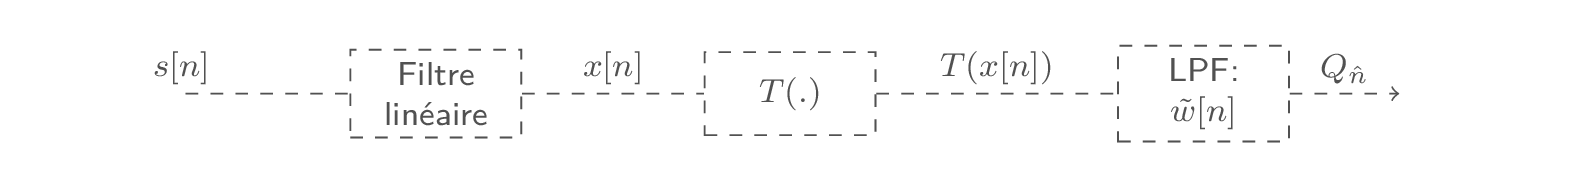

In [11]:
%%tikz --scale=1.0 --border=10
\def\Mycolor{black!75}
\usetikzlibrary{decorations.markings}
\tikzset{every node/.style={font=\footnotesize\sf,\Mycolor,text width =0.1\textwidth,align=center,inner ysep=0.5ex}}
\node[text=black,inner sep =0pt] (in) at (0,0) {};
\node[draw,rectangle,dashed,text=\Mycolor,anchor=west,inner ysep=3pt] at (2,0) (LF) {Filtre lin\'{e}aire};
\node[draw,rectangle,dashed,text=\Mycolor,anchor=west,inner ysep=6pt] at (5,0)(T){$T(.)$};
\node[draw,rectangle,dashed,text=\Mycolor,anchor=west,inner ysep=3pt] at (8.5,0)(LPF){LPF: $\tilde{w}[n]$};
\node[text=black,inner sep =0pt] (out) at (11.5,0) {};
\draw[->,dashed,black!75,anchor=west] (in.east) to node [above left] {$s[n]$} (LF.west)
									(LF.east) to node [above] {$x[n]$} (T.west)
									(T.east) to node [above] {$T(x[n])$} (LPF.west)
									(LPF.east) to node [above] {$Q_{\hat{n}}$} (out.west);

#### 3.1.2 Exemples de fonctions de fenêtrage 

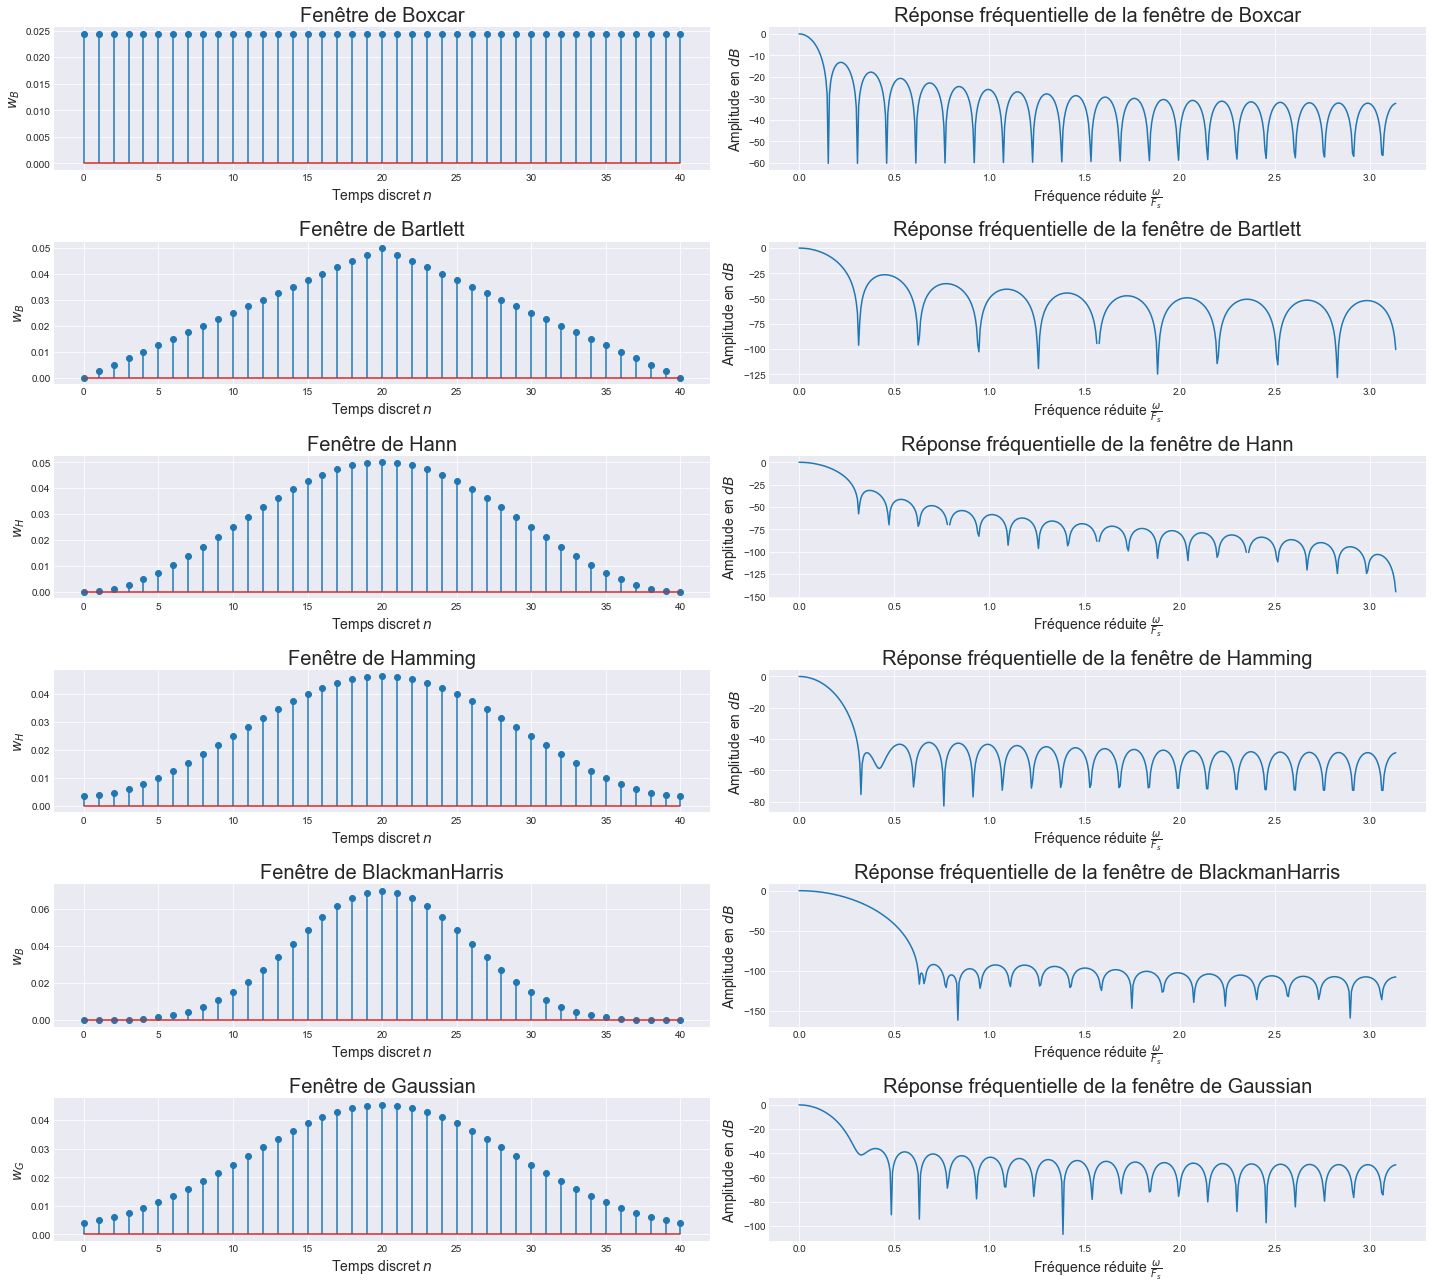

In [12]:
from scipy.signal import windows,freqz
import warnings
warnings.filterwarnings('ignore')
L=41
win_name=["Boxcar","Bartlett","Hann","Hamming","BlackmanHarris","Gaussian"]
fig, ax=plt.subplots(6,2,figsize=(20,18))
for i, name in enumerate(win_name):
    window=getattr(windows,name.lower())
    if name =="Gaussian":
        win=window(L,std=9,sym=True)/window(L,std=9,sym=True).sum()
    else:
        win=window(L,sym=True)/window(L,sym=True).sum()
    
    w, Win=freqz(win)
    ax[i][0].stem(win,use_line_collection=True)
    ax[i][0].set_title("Fenêtre de {}".format(name),fontsize=20)
    ax[i][0].set_xlabel("Temps discret $n$",fontsize=14)
    ax[i][0].set_ylabel("$w_{}$".format(name[0]),fontsize=14)
    ax[i][0].grid(True)
    ax[i][1].plot(w,20*np.log10(abs(Win)))
    ax[i][1].set_title("Réponse fréquentielle de la fenêtre de {}".format(name),fontsize=20)
    ax[i][1].set_xlabel(r"Fréquence réduite $\frac{\omega}{F_s}$",fontsize=14)
    ax[i][1].set_ylabel("Amplitude en $dB$",fontsize=14)
    ax[i][1].grid(True)
fig.tight_layout()
    

#### 3.1.3 Energie courte-durée :
En général, l'expression de l'énergie d'une signal discret est donnée par :
$$ E = \underset{m}{\sum}x^2[m]$$
Pour un signal instationnaire, cette expression ne permet pas de capturer la variabilité énergétique du dite signal. Par contre l'énergie à court-terme le permet :
$$\begin{aligned} E_{\hat{n}} &= \underset{m}{\sum}x_{\hat{n}}^2[m]\\
&= \underset{m}{\sum}\left(x[m]w(\hat{n}-m)\right)^2\\
&= \underset{m}{\sum}x^2[m]\tilde{w}(\hat{n}-m)\\
\end{aligned}$$

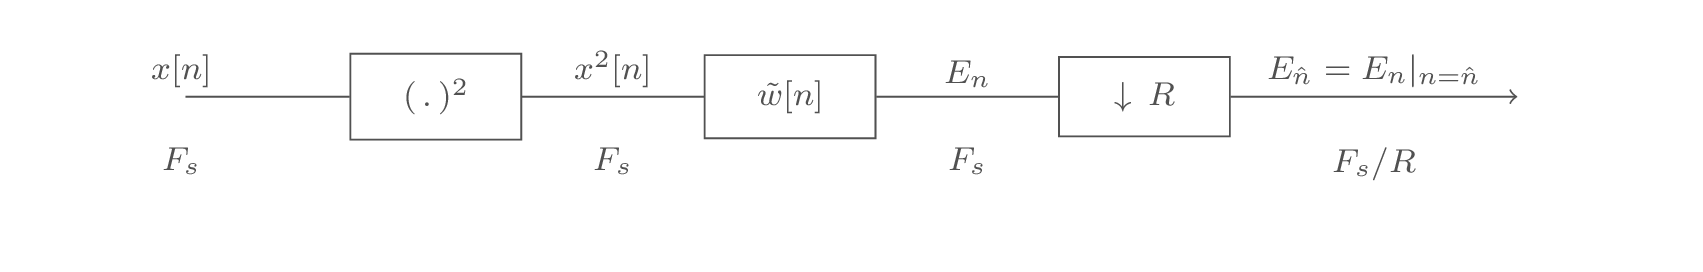

In [13]:
%%tikz --scale=1.0 --border=10
\def\Mycolor{black!75}
\usetikzlibrary{decorations.markings}
\tikzset{every node/.style={font=\footnotesize\sf,\Mycolor,text width =0.1\textwidth,align=center,inner ysep=0.5ex}}
\node[text=black,inner sep =0pt] (in) at (0,0) {};
\node[draw,rectangle,text=\Mycolor,anchor=west,inner ysep=6pt] at (2,0) (T) {$(\, . \,)^2$};
\node[draw,rectangle,text=\Mycolor,anchor=west,inner ysep=6pt] at (5,0)(LPF){$\tilde{w}[n]$};
\node[draw,rectangle,text=\Mycolor,anchor=west,inner ysep=6pt] at (8,0)(D){$\downarrow R$};
\node[text=black,inner sep =0pt] (out) at (12.5,0) {};
\draw[->,black!75,anchor=west] (in.east) to node [above left] {$x[n]$} node [swap,below left,inner ysep=12pt] {$F_s$} (T.west)
    (T.east) to node [above] {$x^2[n]$} node [swap,below,inner ysep=12pt] {$F_s$} (LPF.west)
    (LPF.east) to node [above] {$E_n$} node [swap,below,inner ysep=12pt] {$F_s$} (D.west)
    (D.east) to node [above,text width=0.15\textwidth] {$E_{\hat{n}}=E_n\vert_{n=\hat{n}}$} node [swap,below,inner ysep=12pt] {$F_s/R$} (out.west);

* Exemple de fenêtre rectangulaire :
  Dans le cas de la fenêtre rectangulaire on a $\tilde{w}[n] = w[n]$ ce qui implique :
  $$ E_{\hat{n}}=\underset{m=\hat{n}-L+1}{\overset{\hat{n}}{\sum} x^2[m]} $$ 

  |![Image](images/comp_window_ill.png)|
  |------------------------------------|

In [14]:
snd, sr = librosa.load('audio/what_she_said.wav')
#E=E/E.max()
#X = librosa.stft(snd,window='hamming',win_length=int(0.02*sr))
#Xdb = librosa.amplitude_to_db(abs(X))
ipd.Audio(snd, rate=sr)

In [15]:
interactive_plot=interactive(energy_plot,
                             wtt=widgets.FloatSlider(min=0.01,max=0.05,step=0.005,value=0.025),
                             winname=widgets.ToggleButtons(
                                 options=['boxcar', 'hamming', 'blackmanharris'],
                                 description ="Window: ",
                                 disable=False
                             ))
interactive_plot

interactive(children=(FloatSlider(value=0.025, description='wtt', max=0.05, min=0.01, step=0.005), ToggleButto…

#### 3.1.4 Amplitude courte-durée
Elle se définit comme suit :
$$M_{\hat{n}}= \underset{m}{\sum}\vert x[m]\vert\tilde{w}(\hat{n}-m)$$

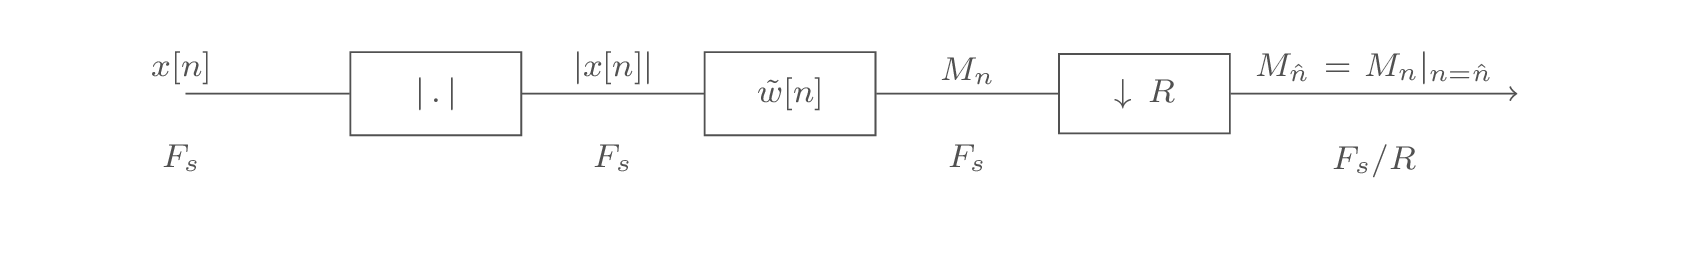

In [16]:
%%tikz --scale=1.0 --border=10
\centerline{
\def\Mycolor{black!75}
\usetikzlibrary{decorations.markings}
\tikzset{every node/.style={font=\footnotesize\sf,\Mycolor,text width =0.1\textwidth,align=center,inner ysep=0.5ex}}
\node[text=black,inner sep =0pt] (in) at (0,0) {};
\node[draw,rectangle,text=\Mycolor,anchor=west,inner ysep=6pt] at (2,0) (T) {$\vert\, . \,\vert$};
\node[draw,rectangle,text=\Mycolor,anchor=west,inner ysep=6pt] at (5,0)(LPF){$\tilde{w}[n]$};
\node[draw,rectangle,text=\Mycolor,anchor=west,inner ysep=6pt] at (8,0)(D){$\downarrow R$};
\node[text=black,inner sep =0pt] (out) at (12.5,0) {};
\draw[->,black!75,anchor=west] (in.east) to node [above left] {$x[n]$} node [swap,below left,inner ysep=12pt] {$F_s$} (T.west)
    (T.east) to node [above] {$\vert x[n] \vert$} node [swap,below,inner ysep=12pt] {$F_s$} (LPF.west)
    (LPF.east) to node [above] {$M_n$} node [swap,below,inner ysep=12pt] {$F_s$} (D.west)
    (D.east) to node [above,text width=0.2\textwidth] {$M_{\hat{n}}=M_n\vert_{n=\hat{n}}$} node [swap,below,inner ysep=12pt] {$F_s/R$} (out.west);}

In [17]:
interactive_plot=interactive(amp_plot,
                             wtt=widgets.FloatSlider(min=0.01,max=0.05,step=0.005,value=0.025),
                             winname=widgets.ToggleButtons(
                                 options=['boxcar', 'hamming', 'blackmanharris'],
                                 description ="Window: ",
                                 disable=False
                             ))
interactive_plot

interactive(children=(FloatSlider(value=0.025, description='wtt', max=0.05, min=0.01, step=0.005), ToggleButto…

#### 3.1.5 Taux de passage par zéro court-durée
Il se définit comme suit :
$$Z_{\hat{n}}= {1\over 2 L_{\text{eff}}} \underset{m}{\sum}\vert sgn(x[m])-sgn(x[m-1])\vert\tilde{w}(\hat{n}-m)$$

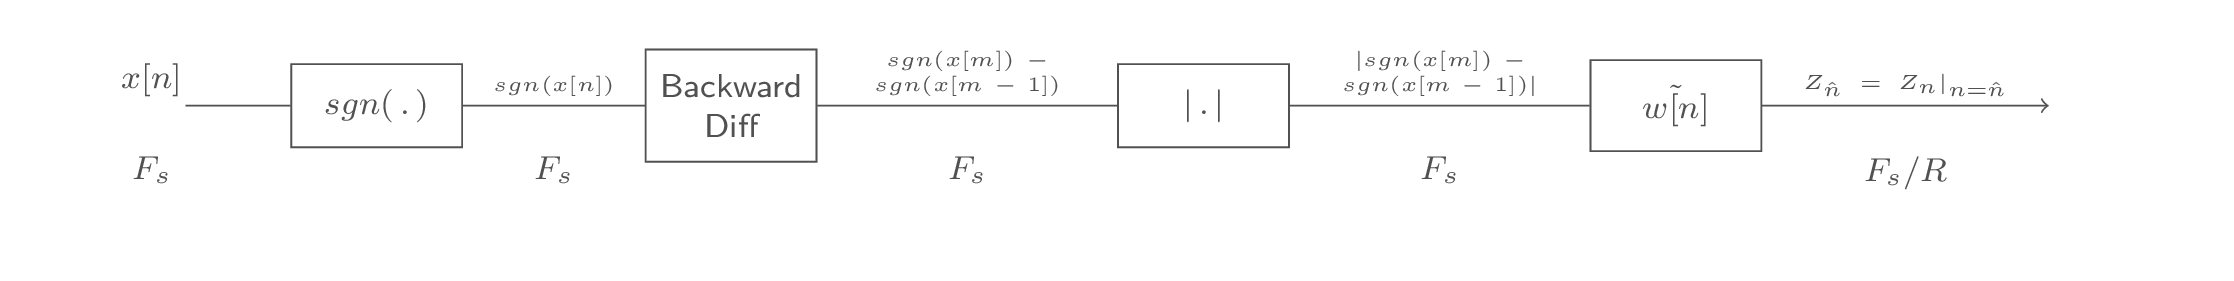

In [18]:
%%tikz --scale=1.0 --border=10
\def\Mycolor{black!75}
\usetikzlibrary{decorations.markings}
\tikzset{every node/.style={font=\footnotesize\sf,\Mycolor,text width =0.1\textwidth,align=center,inner ysep=0.5ex}}
\node[text=black,inner sep =0pt] (in) at (-2.5,0) {};
\node[draw,rectangle,text=\Mycolor,anchor=west,inner ysep=6pt] at (-1,0) (sgn) {$sgn(\, . \,)$};
\node[draw,rectangle,text=\Mycolor,anchor=west,inner ysep=6pt] at (2,0) (DF) {Backward Diff};
\node[draw,rectangle,text=\Mycolor,anchor=west,inner ysep=6pt] at (6,0)(vabs){$\vert \, .\, \vert $};
\node[draw,rectangle,text=\Mycolor,anchor=west,inner ysep=6pt] at (10,0)(LPF){$\tilde{w[n]}$};
\node[text=black,inner sep =0pt] (out) at (14.5,0) {};
\draw[->,black!75,anchor=west] 
    (in.east) to node [above left] {$x[n]$} node [swap,below left,inner ysep=12pt] {$F_s$} (sgn.west)
    (sgn.east) to node [above,font=\tiny]{$ sgn(x[n])$} node [swap,below,inner ysep=12pt] {$F_s$} (DF.west)
    (DF.east) to node [above,font=\tiny,text width=0.2\textwidth]{$ sgn(x[m])-sgn(x[m-1])$} node [swap,below,inner ysep=12pt] {$F_s$} (vabs.west)
	(vabs.east) to node [above,text width=0.2\textwidth,font=\tiny] {$\vert sgn(x[m])-sgn(x[m-1]) \vert$} node [swap,below,inner ysep=12pt] {$F_s$} (LPF.west)
    (LPF.east) to node [above,text width=0.2\textwidth,font=\tiny] {$Z_{\hat{n}}=Z_n\vert_{n=\hat{n}}$} node [swap,below,inner ysep=12pt] {$F_s/R$} (out.west);

In [19]:
interactive_plot=interactive(zc_plot,
                             wtt=widgets.FloatSlider(min=0.01,max=0.05,step=0.005,value=0.025),
                             winname=widgets.ToggleButtons(
                                 options=['boxcar', 'hamming', 'blackmanharris'],
                                 description ="Window: ",
                                 disable=False
                             ))
interactive_plot

interactive(children=(FloatSlider(value=0.025, description='wtt', max=0.05, min=0.01, step=0.005), ToggleButto…

#### 3.1.6 Autocorrélation courte-durée
* Dans le cas d'un signal numérique déterministe, la fonction d'autocorrélation se définit comme suit :
  $$\phi[k] = \underset{m}{\sum} x[m] x[m+k],\text{avec} :\; k\in \mathbb{Z}$$
* Pour un signal aléatoire stationnaire et ergodique, la fonction d'autocorrélation prend la forme suivante :
  $$\begin{aligned}
    \phi[k] &= \text{E}\{x[m]x[m+k]\} \\
            &= \underset{N\rightarrow\infty}{\lim}{1\over 2N+1}\underset{m=-N}{\overset{N}{\sum}}x[m]x[m+k] \\
  \end{aligned}$$
* Propriétés de l'autocorrélation :
  1. Périodicité : si le signal $x[n]$ est périodique de période $N_p$ alors :
      $$ \phi[k+N_p]=\phi[k]$$
  2. Parité : 
     $$ \phi[-k]=\phi[k]$$
  3. L'autocorrélation possède un maximum globale à son origine :
     $$\phi[k]\le\phi[0]\;\forall k$$
  4. La quantité $\phi[0]$ est égale à l'énergie totale dans le cas d'un signal à énergie finie et à la puissance totale moyenne dans le cas d'un signal périodique ou aléatoire. 
* Utilité de la fonction d'autocorrélation :
  1. Estimation de la périodicité d'un signal à partir de sa réalisation temporelle;
  2. Estimation de la densité spectrale d'énergie ou de puissance d'un signal donnée;
* Définition de l'autocorrélation à courte-durée :
$$ R_{\hat{n}}[k] = \underset{m}{\sum}x[m]x[m+k]w[\hat{n}-m]w[\hat{n}-m-k]$$
  Le paramètre $k$ est appelé indice de décalage de l'autocorrélation. En pratique $R_{\hat{n}}[k]$ est évalué pour des valeurs de $k$ dans l'intervalle $[0,...,K]$ avec $K$ est l'indice maximal de décalage retenue dans le cadre d'une étude donnée. La fonction d'autocorrélation à courte-durée hérite de toutes les propriétés de l'autocorrélation normale.
* En exploitant la parité de $R_{\hat{n}}[k]$ on reécrit son expression comme suit :
  $$\begin{aligned}
    R_{\hat{n}}[k] &= R_{\hat{n}}[-k] \\
                   &= \underset{m}{\sum}x[m]x[m-k]w[\hat{n}-m]w[\hat{n}+k-m], Posant:\; \tilde{w}_k[\hat{n}]=w[\hat{n}]w[\hat{n}+k] \\
                   &=\underset{m}{\sum}x[m]x[m-k]\tilde{w}_k[\hat{n}-m] 
  \end{aligned}$$

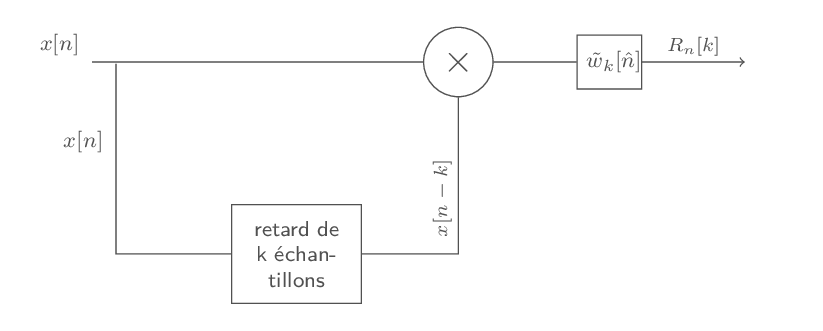

In [20]:
%%tikz  --scale=0.65 --border=10
\def\Mycolor{black!75}
\usetikzlibrary{decorations.markings}
\tikzset{every node/.style={font=\footnotesize\sf,\Mycolor,text width =0.05\textwidth,align=center,inner ysep=0.5ex}}
\node[text=black,inner sep =0pt] (in) at (0,0) {};
\node[draw,rectangle,text=\Mycolor,anchor=west,inner ysep=6pt, text width =0.12\textwidth] at (1.5,-2.5)(delay){retard de k échantillons};
\node[draw,circle,text=\Mycolor,anchor=west,inner ysep=0pt, font=\Large] at (4,0)(mixer){$\times$};
\node[draw,rectangle,text=\Mycolor,anchor=west,inner ysep=6pt] at (6,0)(wind){$\tilde{w}_k[\hat{n}]$};
\node[text=black,inner sep =0pt] (out) at (8.5,0) {};
\draw[->,black!75,anchor=west] 
    (in.south) |- node [near start, above left] {$x[n]$} (delay.west)
    (delay.east) -| node [above right,font=\scriptsize,text width =0.1\textwidth,rotate=90]{$x[n-k]$} (mixer.south)
	 (in.west) |- node [near start, above left] {$x[n]$} (mixer.west)
    (mixer.east) -- (wind.west)
	(wind.east) to node [above,text width=0.2\textwidth,font=\scriptsize] {$R_n[k]$} (out.west);

* En pratique en utilise l'expression ci-après pour le calcul de l'autocorrélation courte-durée sur un ordinateur :
$$R_{\hat{n}}[k]=\underset{m=0}{\overset{L-1-k}{\sum}}x[\hat{n}+m]w'[m]x[\hat{n}+m+k]w'[k+m], \text{avec:}\; w'[m] = w[-m] $$

|![Image](images/st_acf.png)|
|---------------------------|

* Remarquons que la fonction d'autocorrélation à courte-durée est fortement pénalisée par les grandes valeurs de $K$. Pour palier à ce problème, on introduit une version modifié de $R_{\hat{n}}[k]$ tel que :
$$ \tilde{R}_{\hat{n}}[k] = \underset{m}{\sum}x[\hat{n}+m]\tilde{w}_1[m]x[\hat{n}+m+k]\tilde{w}_2[k+m], \tilde{w}_1[m]=\left\{\begin{matrix} 1 & 0\le m \le L-1 \\ 0 & ailleurs \\  \end{matrix} \right. \, et\; \tilde{w}_2[m]=\left\{\begin{matrix} 1 & 0\le m \le L-1+K \\ 0 & ailleurs \\  \end{matrix} \right.$$

#### 3.1.7 Magnétude moyenne de la différence à courte-durée
L'estimation du pitch à partir de la fonction d'auto-corrélation est une opération gourmande en puissance de calcul ce qui nous amène à utiliser une autre approche pour aboutir au même résultat. L'astuce est de remarquer qu'un signal numérique quasi périodique aura toujours presque la même valeur aux multiples entiers de la période $N_p$ du signal. En se basant sur ce fait et en utilisant la fonction différence $d_n$, on peut assumer que cette dernière prend de faibles valeurs en ces points particuliers du signal de la parole voisé:
* Definition :
  $$ AMDF[k] = \underset{m}{\sum}\left\vert x[\hat{n}+m]w_1[m]-x[\hat{n}+m-k]w_2[m-k]\right\vert $$
  

In [21]:
from speech_tools import *
interactive_plot=interactive(AMDF_plot,
                             lag_r=widgets.FloatSlider(min=0.1,max=0.85,step=0.05,value=0.5),
                             win_name=widgets.ToggleButtons(
                                 options=['boxcar', 'hamming', 'blackmanharris'],
                                 description ="Window: ",
                                 disable=False
                             ))
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='lag_r', max=0.85, min=0.1, step=0.05), ToggleButtons…

### 3.2 Spectre courte-durée
#### 3.2.1 Transformée de Fourier à courte-durée 
##### 3.2.1.1  Rappels de la DTFT :
$$ \begin{aligned}
x_e(t) &= \underset{m}{\sum}x[{m\over sr}]\delta(t - {m\over sr}),\text{avec}\; {sr: \text{Sample Rate}}\\
\Longrightarrow X_e(\jmath\omega)&=\underset{m}{\sum}x[{m\over sr}]\exp\left(-\jmath {m\over sr} \omega \right),\text{avec}\; {X(\jmath\omega): \text{Spectre continue du signal discret}\, x[n]\;\text{et}\; {\omega\over sr}\in\left[-\pi, \pi\right]}\\
x[n] &={1\over 2\pi}\int_{-\pi}^{\pi}X(\jmath\omega)\exp\left(\jmath m \omega\right) d\omega,\text{Transformation inverse}\\
\end{aligned}
$$
##### 3.2.1.2 Transformée de Fourier discrète:
$$
\begin{aligned}
X[k]&= \underset{m=0}{\overset{N-1}{\sum}} x[n]\exp\left(-\jmath {2\pi\over N} k m\right),\;\text{TFD directe et}\, k = 0,1,\ldots,N-1\\
x[n]&= {1\over N}\underset{k=0}{\overset{N-1}{\sum}} X[k]\exp\left(\jmath {2\pi\over N} k m\right),\;\text{TFD inverse et}\, m = 0,1,\ldots,N-1\\
\end{aligned}
$$
##### 3.2.1.3 Transformée de Fourier à courte durée (STFT):
* Définition :
  $$
  \begin{aligned}
  X_{\hat{n}}(\jmath\omega)&=\underset{m}{\sum}x[\hat{n}-m]w[m]\exp\left(-\jmath (\hat{n}-m) \omega\right)\\
             &=\exp\left(-\jmath\hat{n} \omega\right)\underset{m}{\sum}x[\hat{n}-m]w[m]\exp\left(\jmath m \omega\right)\\
  \end{aligned}
  $$
  Posant $\tilde{X}_{\hat{n}}(\jmath\omega)= \underset{m}{\sum}x[\hat{n}-m]w[m]\exp\left(\jmath m \omega\right)$, on aura alors :
  $$ X_{\hat{n}}(\jmath\omega)=\exp\left(-\jmath\hat{n} \omega\right)\tilde{X}_{\hat{n}}(\jmath\omega)$$
  L'expression de la STFT peut être interprétée de deux manières différentes :
  * Pour $\hat{n}$ fixe $X_{\hat{n}}$ est une simple transformèe de Fourier discrète d'un segment du signal $x_{\hat{n}}[m]$ autour de l'instant
  discret $\hat{n}$
  * Pour $\omega=\omega_0$ et $\hat{n}$ variable, $X_{\hat{n}}(\omega_0)$ est l'évolution temporelle de la composante spectrale évaluée à la fréquence $\omega_0$
  * On peut exprimer $X_{\hat{n}}(\jmath\omega)$ comme étant un produit de convolution discret :
    $$
    \begin{aligned}
    X_{\hat{n}}(\jmath\omega)&=\exp\left(-\jmath\hat{n} \omega\right)\underset{m}{\sum}x[\hat{n}-m]w[m]\exp\left(\jmath m \omega\right)\\
                           &=\exp\left(-\jmath\hat{n} \omega\right)\left\{x[m]*w(m)\exp\left(\jmath m \omega\right)\right\}[\hat{n}]\\
    \end{aligned}
    $$
  * Transformée inverse de la STFT :
    $$ 
    \begin{aligned}
    w[\hat{n}-m]x[m] &={1 \over 2\pi}\int_{-\pi}^{pi}X_{\hat{n}}(\jmath\omega)\exp\left(\jmath m\omega\right)d\omega\\
    \Longrightarrow x[m]  &= {1 \over 2\pi w[\hat{n}-m]}\int_{-\pi}^{pi}X_{\hat{n}}(\jmath\omega)\exp\left(\jmath m\omega\right)d\omega\\ 
    \end{aligned}
    $$
  * Implémentation DFT de la STFT:
    $$
    \begin{aligned}
    X_{\hat{n}}[k]&=\exp\left(-\jmath {2\pi\over N} \hat{n} k\right)\underset{\tilde{X}_{\hat{n}}[k]}{\underbrace{\underset{m=0}{\overset{N-1}{\sum}}x[\hat{n}+m]w[-m]\exp\left(-\jmath {2\pi\over N} m k\right)}}\quad\forall k=0,1,2\ldots,N-1  
    \end{aligned}
    $$
    * Algorithme de calcul de $X_{\hat{n}}[k]$ :
      1. Selectionner L échantillons à partir de $\hat{n}$ pour une fenêtre $w[m]$ non causale et précédant $\hat{n}$ dans le cas inverse.
      2. Multiplier cette séquence par la fenêtre temporelle inversé dans le temps $w[-m]$ pour tout $m=0,1,2,\ldots,N-1$.
      3. Calculer $\tilde{X}_{\hat{n}}[k]$ sur N points en utilisant la FFT.
      4. Si on est interessé par la phase de la STFT, multiplier par $\exp\left(-\jmath {2\pi\over N} \hat{n} k\right)$ sinon :
      $$\left\vert X_{\hat{n}}[k] \right\vert=\left\vert \tilde{X}_{\hat{n}}[k] \right\vert $$
      5. $X_{\hat{n}}[k]$ est couremment évalué aux instant discret $\hat{n}=r R$ avec $r, R\in\mathbb{N}$ et $R\le L$.

##### 3.2.1.4 Exemple de spectres à courte-durée :

In [25]:
interactive_plot=interactive(spec_plot,
                             wintt=widgets.FloatSlider(min=10e-3,max=40e-3,step=5e-3,value=20e-3),
                             fname=widgets.ToggleButtons(
                                 options=['AEUI', 'BDG', 'Diphtongue','FSCHTH'],
                                 description="File_name: ",
                                 disable=False
                             ),
                             win_name=widgets.ToggleButtons(
                                 options=['boxcar', 'hamming', 'blackmanharris','hann'],
                                 description="Window: ",
                                 disable=False
                             ),
                             n_fft = widgets.IntSlider(value=int(2**10),
                                                            min=int(2**10),
                                                            max=int(2**13),
                                                            step = 1024,
                                                            orientation='horizontal',
                                                            readout=True,
                                                            description = 'Nfft',
                                                            readout_format='d'))
interactive_plot

interactive(children=(ToggleButtons(description='File_name: ', options=('AEUI', 'BDG', 'Diphtongue', 'FSCHTH')…